# Models plots

In [2]:
import sys
from pathlib import Path

import os
from pathlib import Path
NOTEBOOK_DIR = Path(os.getcwd())
ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from src.utils.config_resolver import load_config
from src.features.add_autoregressive import add_battery_current_ar
from src.utils.metrics import battery_current_metrics, battery_soc_metrics, print_metrics
from src.data.load_data import load_flights
from src.data.train_test_split import train_test_split_flight
from src.data.filter_dummy_flights import filter_dummy_flights
from src.features.add_features import add_features
from src.features.soc_estimation import compute_soc
from src.features.add_is_flying import add_is_flying
import joblib
from src.utils.path_resolver import MODELS_DIR
from src.models.RNN.lstm_model import LSTMModel
from src.models.RNN.scale_features import Scalers
from src.models.lstm import predict_on_df
import torch

In [3]:
def plot_flight_results(df, flight_id, model_name="Model"):
    plot_data = df[df["flight"] == flight_id].sort_values("time").copy()
    plot_data["dt_sec"] = plot_data["time"].diff().fillna(0.0)

    for suffix in ["", "_pred"]:
        curr_col = f"battery_current{suffix}"
        mah_col = f"mAh_used{suffix}"
        cum_col = f"cum_mAh_used{suffix}"
        soc_col = f"soc_coulomb_mAh{suffix}"
        
        plot_data[mah_col] = (plot_data["dt_sec"] / 3600.0) * (plot_data[curr_col] * 1000)
        plot_data[cum_col] = plot_data[mah_col].cumsum()
        total_cap = plot_data["mAh_used"].cumsum().max() 
        plot_data[soc_col] = total_cap - plot_data[cum_col]

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(plot_data["time"], plot_data["battery_current"], label="Real", color="black", alpha=0.8)
    plt.plot(plot_data["time"], plot_data["battery_current_pred"], label="Predicted", color="blue", alpha=0.7)
    plt.title(f"Flight {flight_id} - Current\n({model_name})")
    plt.ylabel("Amperes (A)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh"], label="Real SoC", color="black")
    plt.plot(plot_data["time"], plot_data["soc_coulomb_mAh_pred"], label="Pred SoC", color="blue", linestyle="--")
    plt.title(f"Flight {flight_id} - SoC Integration")
    plt.ylabel("Capacity (mAh)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# MLR

C:\Users\muric\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


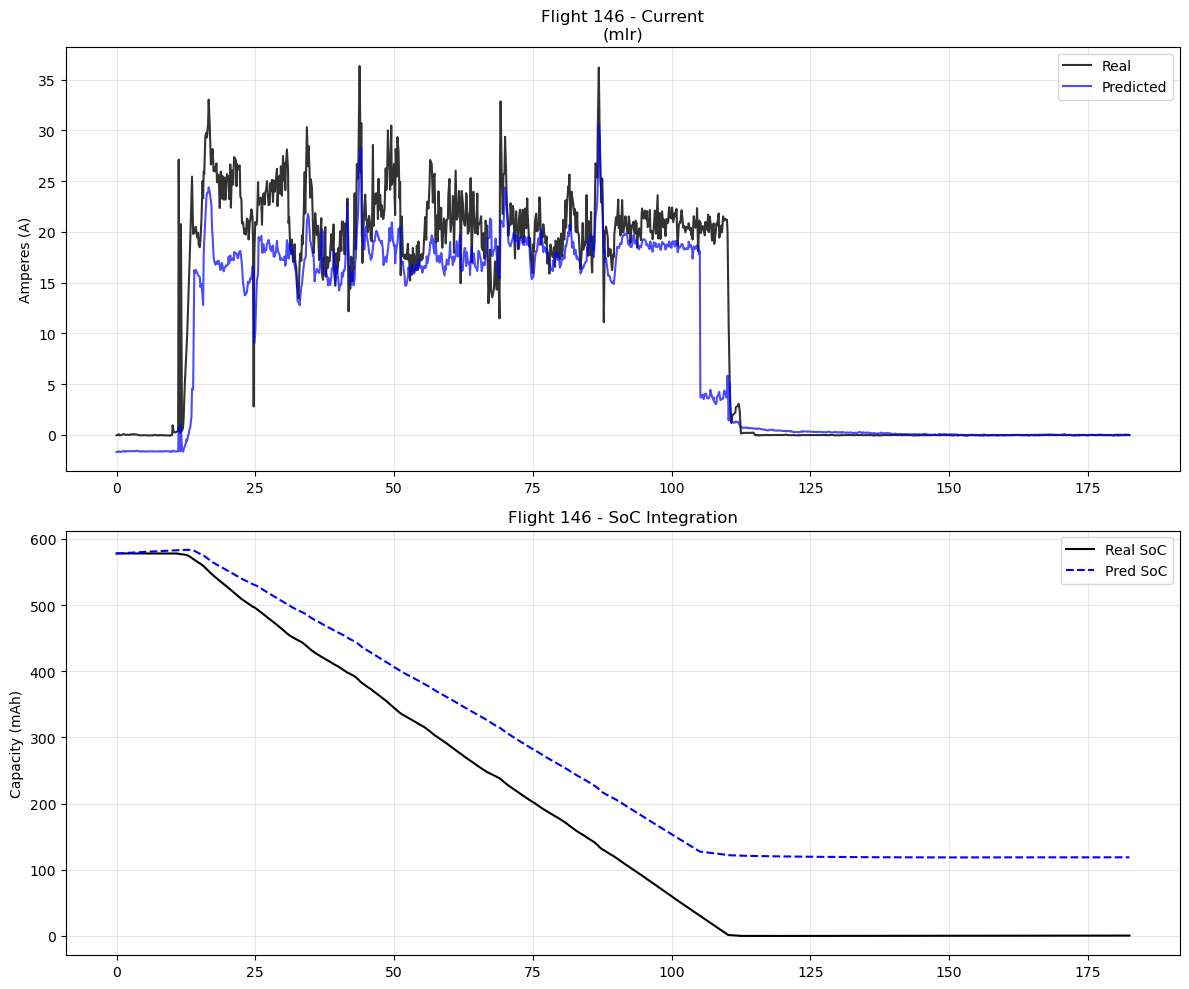

 MLR metrics: 
 CURRENT (Instantaneous Accuracy)
 R2 Score:             0.7682
 MAPE:         16.67 %

 SOC (Cumulative Endurance)
 Final Energy Error:       8.44 %
 Max mAh Deviation:     246.2 mAh
 Avg Curve Drift:        47.2 mAh


In [5]:
# Load dataset
df = load_flights()
df = filter_dummy_flights(df)
df = add_features(df)
df = compute_soc(df)
df = add_is_flying(df)

# Configuration and prediction
cfg = load_config("MLR.yaml")
features = cfg["features"]
model_name = cfg["model"]["name"]
train_df, test_df = train_test_split_flight(df, split_ratio=cfg["train_split"])

model = joblib.load(MODELS_DIR / "mlr.pkl")
test_df = test_df.copy()
test_df["battery_current_pred"] = model.predict(test_df[features].fillna(0.0))
    
# Show graphs for one chosen flight
random_id = np.random.choice(test_df["flight"].unique())
plot_flight_results(test_df, random_id, model_name=model_name)

# Metrics
curr_m = battery_current_metrics(test_df["battery_current"], test_df["battery_current_pred"])
soc_m = battery_soc_metrics(test_df, test_df["battery_current_pred"])
print_metrics(model_name, curr_m, soc_m)

# XGBoost

C:\Users\muric\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:59:30] WARNING: D:\bld\xgboost-split_1737531311373\work\src\gbm\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


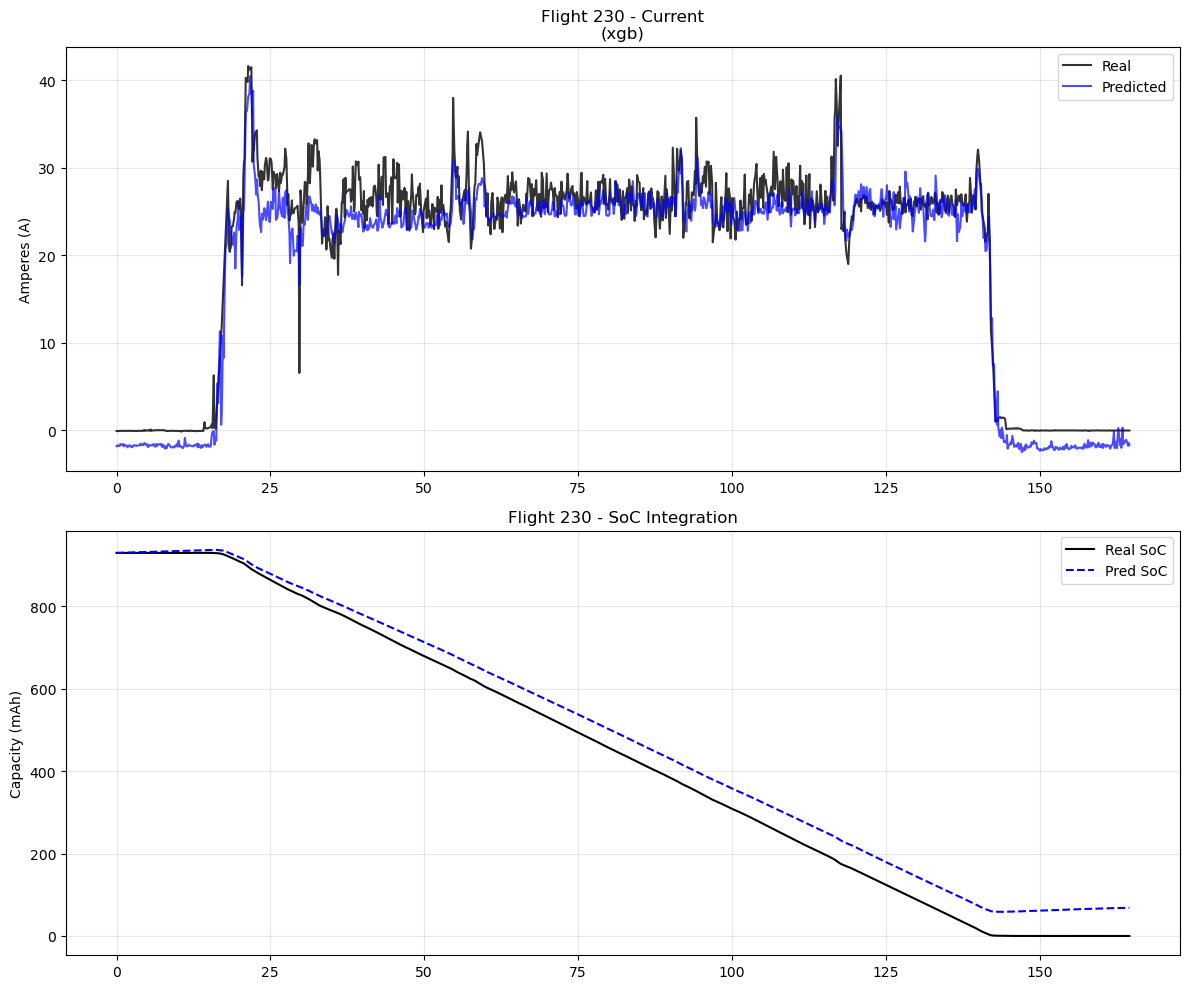

 XGB metrics: 
 CURRENT (Instantaneous Accuracy)
 R2 Score:             0.8814
 MAPE:         14.69 %

 SOC (Cumulative Endurance)
 Final Energy Error:      10.60 %
 Max mAh Deviation:     172.9 mAh
 Avg Curve Drift:        61.6 mAh


In [7]:
# Load dataset
df = load_flights()
df = filter_dummy_flights(df)
df = add_features(df)
df = compute_soc(df)
df = add_is_flying(df)

# Configuration and prediction
cfg = load_config("XGB.yaml")
features = cfg["features"]
model_name = cfg["model"]["name"]
train_df, test_df = train_test_split_flight(df, split_ratio=cfg["train_split"])

model = joblib.load(MODELS_DIR / "xgb.pkl")
test_df = test_df.copy()
test_df["battery_current_pred"] = model.predict(test_df[features].fillna(0.0))

# Show graphs for one chosen flight
random_id = np.random.choice(test_df["flight"].unique())
plot_flight_results(test_df, random_id, model_name=model_name)

# Metrics
curr_m = battery_current_metrics(test_df["battery_current"], test_df["battery_current_pred"])
soc_m = battery_soc_metrics(test_df, test_df["battery_current_pred"])
print_metrics(model_name, curr_m, soc_m)

# XGBoost with AutoRegression (battery current - lag 1)

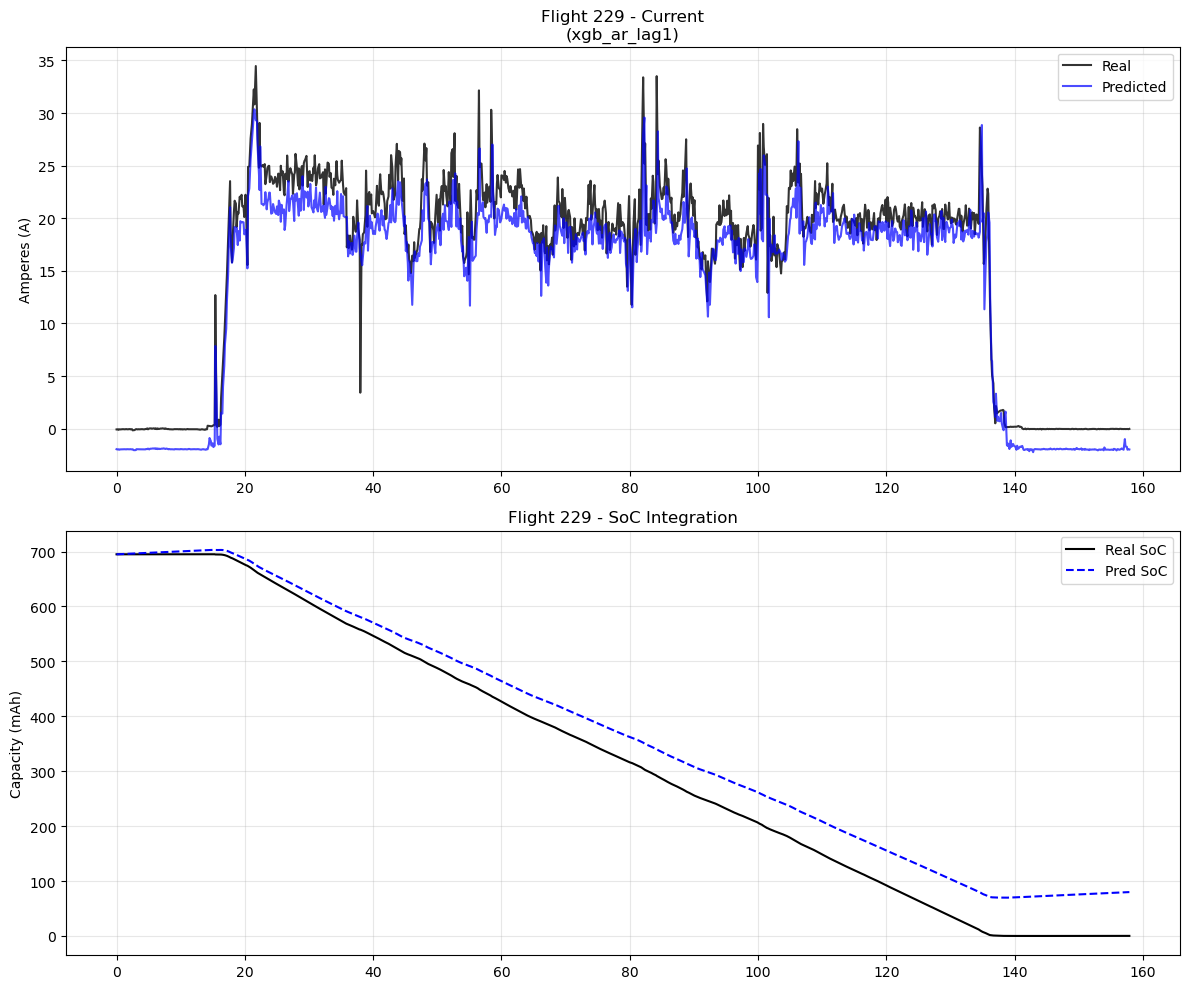

 XGB_AR_LAG1 metrics: 
 CURRENT (Instantaneous Accuracy)
 R2 Score:             0.9394
 MAPE:         10.89 %

 SOC (Cumulative Endurance)
 Final Energy Error:      10.61 %
 Max mAh Deviation:     208.4 mAh
 Avg Curve Drift:        53.3 mAh


In [9]:
# Load dataset
df = load_flights()
df = filter_dummy_flights(df)
df = add_features(df)
df = compute_soc(df)
df = add_is_flying(df)
df = add_battery_current_ar(df)

# Configuration and prediction
cfg = load_config("XGB_AR_lag1.yaml")
features = cfg["features"]
model_name = cfg["model"]["name"]
train_df, test_df = train_test_split_flight(df, split_ratio=cfg["train_split"])

model = joblib.load(MODELS_DIR / "xgb_ar_lag1.pkl")
test_df = test_df.copy()
test_df["battery_current_pred"] = model.predict(test_df[features].fillna(0.0))

# Show graphs for one chosen flight
random_id = np.random.choice(test_df["flight"].unique())
plot_flight_results(test_df, random_id, model_name=model_name)

# Metrics
curr_m = battery_current_metrics(test_df["battery_current"], test_df["battery_current_pred"])
soc_m = battery_soc_metrics(test_df, test_df["battery_current_pred"])
print_metrics(model_name, curr_m, soc_m)

# LSTM - 2 recurent layers, 64 size each, regression head, 100 sequence size

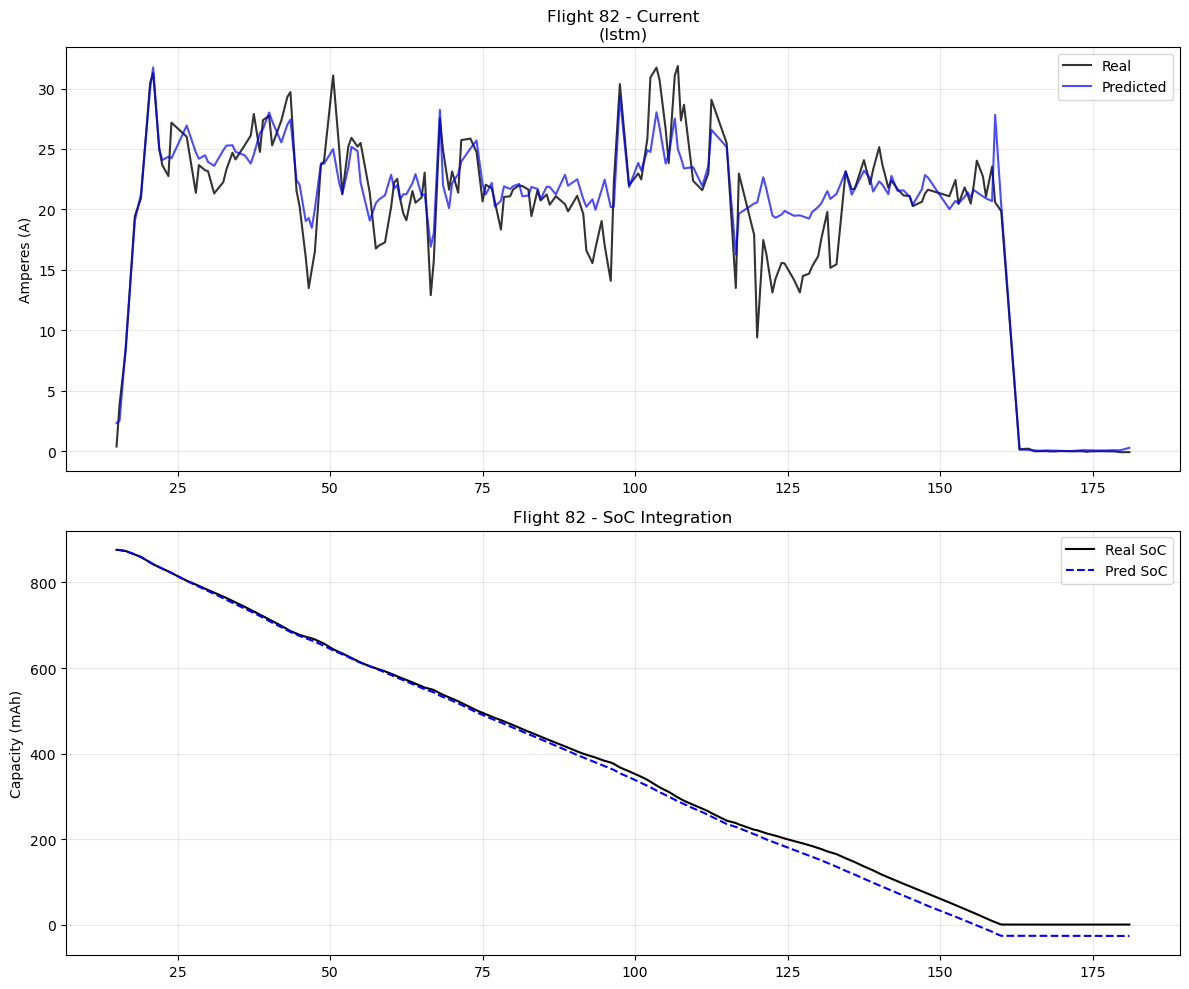

 LSTM metrics: 
 CURRENT (Instantaneous Accuracy)
 R2 Score:             0.9298
 MAPE:          9.84 %

 SOC (Cumulative Endurance)
 Final Energy Error:       2.31 %
 Max mAh Deviation:     102.9 mAh
 Avg Curve Drift:        14.2 mAh


In [19]:
df = load_flights()
df = filter_dummy_flights(df)
df = add_features(df)
df = compute_soc(df)
df = add_is_flying(df)

# Split
cfg = load_config("LSTM.yaml")
model_name = cfg["model"]["name"]
train_df, test_df = train_test_split_flight(df, split_ratio=cfg["train_split"])

bundle = torch.load(MODELS_DIR / f"{model_name}.pth", map_location="cpu")
lstm_features = bundle["features"]
model_cfg = bundle["model_config"]
seq_len = int(model_cfg["seq_len"])

model = LSTMModel(
    input_dim=len(lstm_features),
    hidden_size=int(model_cfg["hidden_size"]),
    num_layers=int(model_cfg["num_layers"]),
    dropout=float(model_cfg["dropout"]),
)

model.load_state_dict(bundle["model_state_dict"])
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

scalers = Scalers.from_dict(bundle["scalers"])

pred_df = predict_on_df(
    model=model,
    df=test_df,
    features=lstm_features,
    scalers=scalers,
    seq_len=seq_len,
    device=device,
    target_col="battery_current",
)

test_df_lstm = test_df.merge(
    pred_df[["flight", "time", "battery_current_pred"]],
    on=["flight", "time"],
    how="left",
)

test_df_lstm = test_df_lstm.dropna(subset=["battery_current_pred"]).copy()

random_id = int(np.random.choice(test_df_lstm["flight"].unique()))
plot_flight_results(test_df_lstm, random_id, model_name=model_name)

curr_m = battery_current_metrics(test_df_lstm["battery_current"], test_df_lstm["battery_current_pred"])
soc_m = battery_soc_metrics(test_df_lstm, test_df_lstm["battery_current_pred"])
print_metrics(model_name, curr_m, soc_m)
